The bandpassing method using a filter to separate the CF and the FM is good - but I'm not able to very reliable segmentation all the time. Finally, now I'm thinking - the FM and Cf components are defined by how the frequencies change over time. Why should I not directly use this then in the code implementation?

- Thejasvi Beleyur, 
2020-03-07

In [1]:
import scipy.signal as signal 
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000

In [2]:
%matplotlib notebook

In [3]:
import sys 
sys.path.append('../measure_horseshoe_bat_calls/')

In [38]:
import pandas as pd
import scipy.io.wavfile as wav
from measure_a_horseshoe_bat_call import make_one_CFcall, measure_hbc_call, make_overview_figure
from measure_a_horseshoe_bat_call import get_peak_frequency, remove_frequency, dB, moving_rms

In [24]:
fs = 500000.0
peak_f = 110000.0
fm_durn = 0.002
cf_durn = 0.020
call_parameter = (cf_durn, fm_durn, peak_f, 15000, 0)

cf_durn, fm_durn, peak_f, fm_bw, _ = call_parameter
eg_call =  make_one_CFcall(cf_durn+fm_durn*2, fm_durn, cf_freq=peak_f, fs=fs,
                                                           call_shape='staplepin',
                                                           fm_bandwidth=fm_bw)
eg_call += np.random.normal(0,10**-10/20.0, eg_call.size)
pad_length = int(0.1*fs)
padded_call = np.pad(eg_call, [pad_length]*2, mode='constant', constant_values=(0,0))

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


In [25]:
def get_peak_frequency_from_fft(power_spectrum, freqs):
    '''
    '''
    max_power_index = np.argmax(abs(power_spectrum))
    peak_frequency = freqs[max_power_index]
    return peak_frequency

def track_dominant_frequency_over_time(audio, fs, **kwargs):
    '''tracks the dominant frequency in an audio snippet across the spectrogram. 
    TODO : 
    1) The spectrogram always outputs < columns than number of audio samples. 
       Right now am repeating the last dominant frequency to 'fill' up to the audio's
       size. Need to work on something that's less approximate - eg. flip audio and
       then take spectrogram etc. 
    2) Handle noise estimates of noise where the dominant frequency changes rapidly 
    '''
    seg_length = kwargs.get('seg_length',256)
    overlap_length = seg_length-1

    f,t,sxx = signal.spectrogram(audio, fs=fs, nperseg=seg_length, noverlap=overlap_length)
    dominant_frequency_w_time = np.apply_along_axis(get_peak_frequency_from_fft, 0, sxx, f)

    # repeat the last dominant frequency to create an array of correct size.
    num_samples_difference = audio.size - dominant_frequency_w_time.size
    frequency_w_time = np.concatenate((dominant_frequency_w_time,
                                       np.tile(dominant_frequency_w_time[-1], num_samples_difference)))
    
    return frequency_w_time

def segment_thru_dominant_frequency(audio, fs, percent_peak=0.98, **kwargs):

    # make spectrogram and get dominant frequency over time. 
    frequency_over_time = track_dominant_frequency_over_time(audio, fs, **kwargs)

    #
    max_dominant = np.max(frequency_over_time)
    threshold_frequency = max_dominant*percent_peak

    cf_part = np.argwhere(frequency_over_time>=threshold_frequency)
    fm_part = np.argwhere(frequency_over_time<threshold_frequency)
    return cf_part, fm_part

<IPython.core.display.Javascript object>


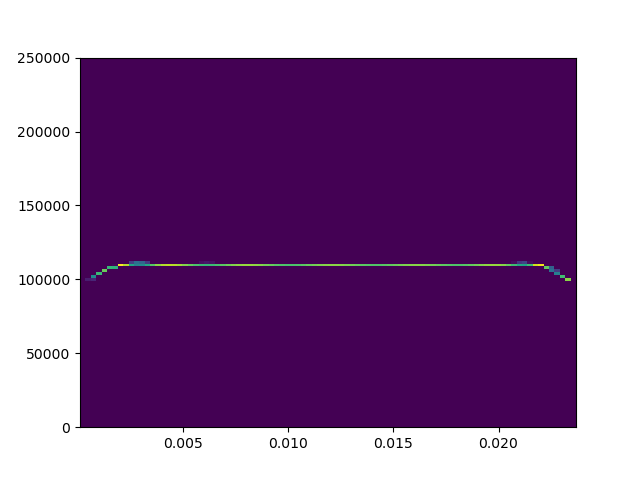

In [26]:
plt.figure()
plt.specgram(eg_call, Fs=fs, vmin=-40);

In [32]:
dom_f = track_dominant_frequency_over_time(eg_call, fs, seg_length=256)

cf, fm = segment_thru_dominant_frequency(eg_call, fs, percent_peak=0.99)

In [33]:
dom_f[-10:]

array([97656.25, 97656.25, 97656.25, 97656.25, 97656.25, 97656.25,
       97656.25, 97656.25, 97656.25, 97656.25])

<IPython.core.display.Javascript object>


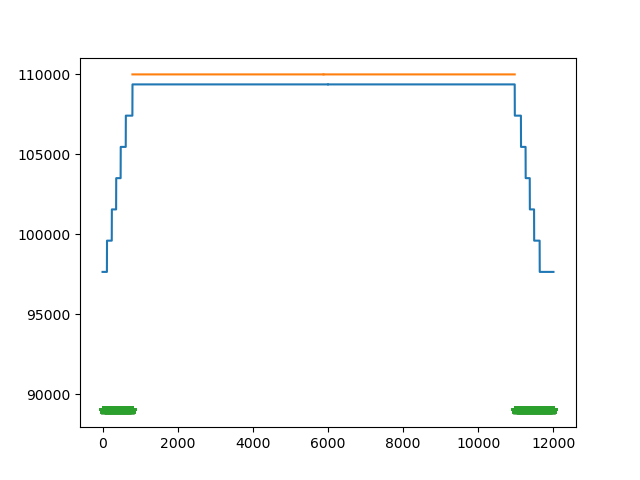

0.020348 0.00159 0.002062
0.02 0.002


In [36]:
plt.figure()
plt.plot(dom_f)
plt.plot(cf, np.tile(110000,cf.size))
plt.plot(fm, np.tile(89000,fm.size),'*')
print(np.sum(cf.size)/fs,  (np.sum(fm<6000)/fs), np.sum(fm>6000)/fs)
print( cf_durn, fm_durn)

<IPython.core.display.Javascript object>


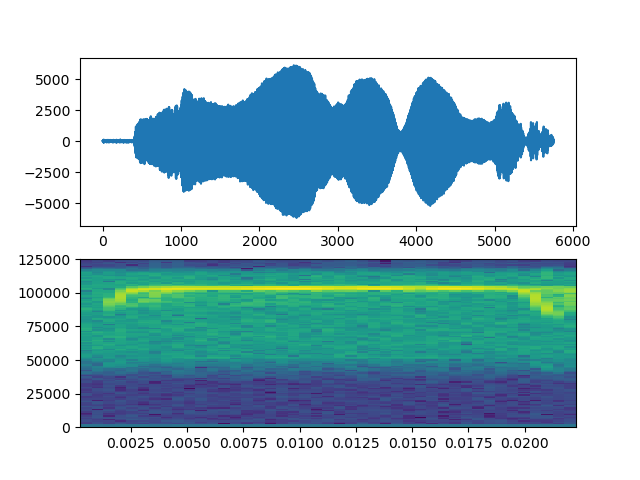

<IPython.core.display.Javascript object>


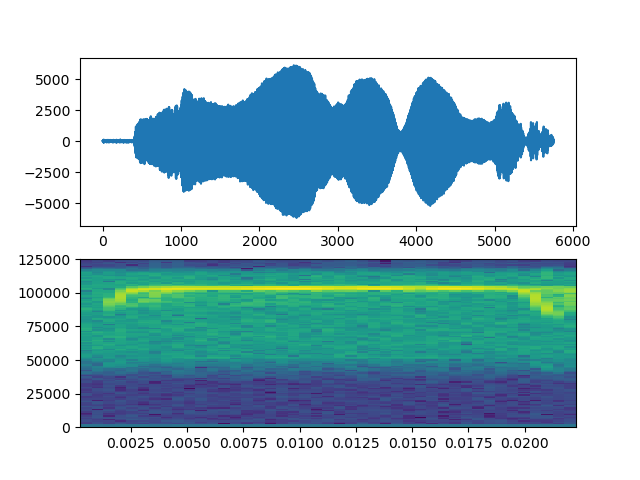

In [62]:
fs, call = wav.read('real_data\\'+'matching_annotaudio_Aditya_2018-08-17_23_141.WAV')
cf, fm  = segment_thru_dominant_frequency(call, fs,)
dom_f = track_dominant_frequency_over_time(call, fs, seg_length=256)

plt.figure()
plt.subplot(211)
plt.plot(call)
plt.subplot(212)
plt.specgram(call, Fs=fs);

<IPython.core.display.Javascript object>


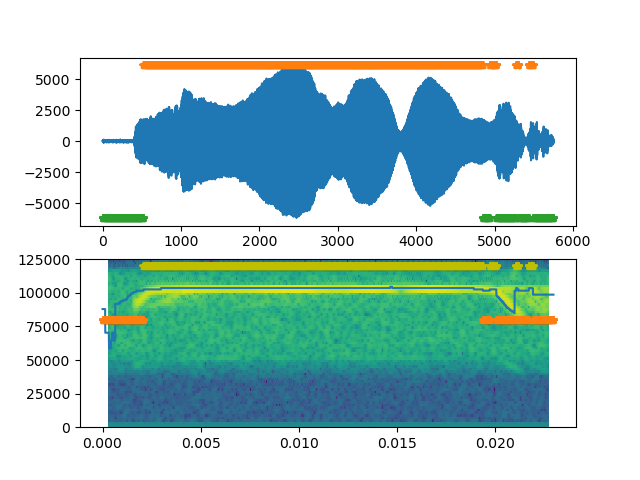

In [61]:
plt.figure()
plt.subplot(211)
plt.plot(call)
plt.plot(cf,np.tile(np.max(call), cf.size),'*')
plt.plot(fm, np.tile(np.min(call), fm.size), '*')
plt.subplot(212)
plt.specgram(call, Fs=fs, NFFT=128, noverlap=127);
plt.plot(np.linspace(0,dom_f.size/fs,dom_f.size), dom_f)
plt.plot(cf/fs,np.tile(120000, cf.size),'y*')
plt.plot(fm/fs, np.tile(80000, fm.size), '*')

<IPython.core.display.Javascript object>


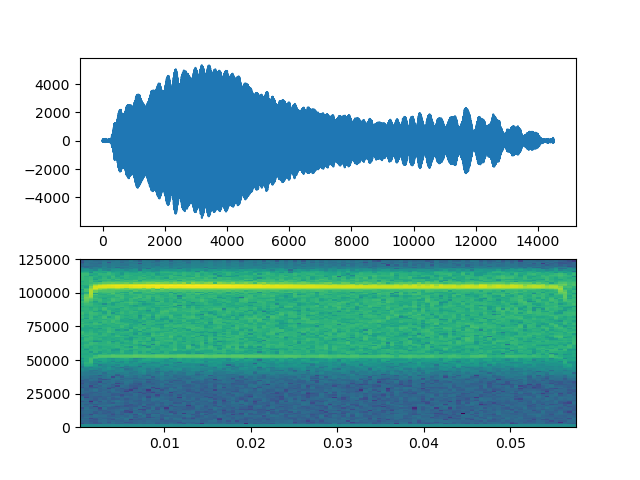

In [63]:
fs, call = wav.read('real_data\\'+'matching_annotaudio_Aditya_2018-08-17_34_18.WAV')
cf, fm  = segment_thru_dominant_frequency(call, fs,)
dom_f = track_dominant_frequency_over_time(call, fs, seg_length=256)

plt.figure()
plt.subplot(211)
plt.plot(call)
plt.subplot(212)
plt.specgram(call, Fs=fs);

<IPython.core.display.Javascript object>


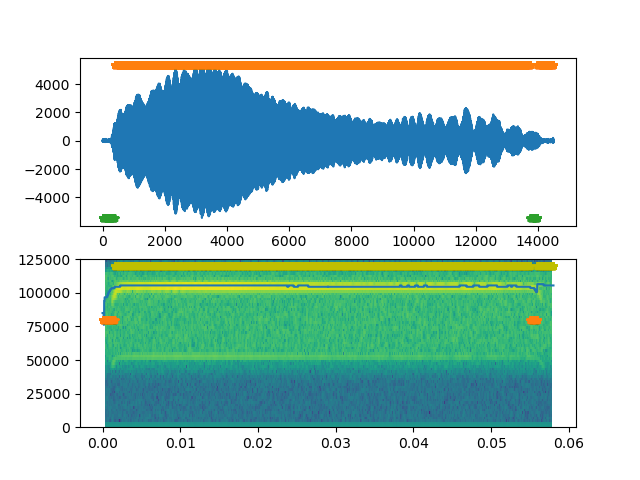

In [64]:
plt.figure()
plt.subplot(211)
plt.plot(call)
plt.plot(cf,np.tile(np.max(call), cf.size),'*')
plt.plot(fm, np.tile(np.min(call), fm.size), '*')
plt.subplot(212)
plt.specgram(call, Fs=fs, NFFT=128, noverlap=127);
plt.plot(np.linspace(0,dom_f.size/fs,dom_f.size), dom_f)
plt.plot(cf/fs,np.tile(120000, cf.size),'y*')
plt.plot(fm/fs, np.tile(80000, fm.size), '*')